<a href="https://colab.research.google.com/github/pavi-ninjaac/Data_Science_internship_program_Technocolaps_July2020/blob/master/Politics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
! pip3 install algorithmia

In [26]:
! pip3 install wordcloud

In [27]:
# import the nedded libraries
import numpy as np
import pandas as pd

import Algorithmia
import wordcloud

In [28]:
def get_data():
    input = {
  "domains": "cnn.com",
  "topic": "politics",
  "q": "",
  "qInTitle": "",
  "content": "false",
  "page": "1",
  "author_only": "True"
    }
    client = Algorithmia.client('simQ9w1MCYmLaZgMqH9r9GoEoXe1')
    algo = client.algo('specrom/LatestNewsAPI/0.1.6')
    algo.set_options(timeout=300) 
    result = algo.pipe(input).result
    
    col_names=['author','description','publishedAt','source_name','source_url','title','url','urlToImage']
    data=[]
    
    for i in result["Article"]:
      data.append(np.array([i[str(x)] for x in col_names]))
    
    df = pd.DataFrame(data=data,columns=col_names)
    
    df.to_csv('F:\spectromNewsAPI\politics_data.csv')
    print("converted sunccesfully!!!!!!!!!!!!!!!")
    

In [29]:
#load file from local system
from google.colab import files
uploaded = files.upload()


Saving politics_data.csv to politics_data (1).csv


In [30]:
import io
df = pd.read_csv(io.BytesIO(uploaded['politics_data.csv']),index_col=0)

#shape of the dataframe
print('The shape of the dataframe is :',df.shape)

The shape of the dataframe is : (94, 8)


In [66]:
# Extract the data
data = df.iloc[:,[1]]
data.head(2)

,description
0,"Gabriel Sterling, the voting systems implement..."
1,President Trump and his allies are repeatedly ...


In [67]:
#Checking for null values in `description`
data['description'].isnull().sum()


0

# ***Data Cleaning***

In [68]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

corpus=[]

for i in range(0,94):
    #subract the letters except alphapet and numbers
    words=re.sub('[^a-zA-Z]',' ',data['description'].iloc[i])
    
    #covert to lower case
    words=words.lower()
    
    #split it to words
    words=words.split()
    
    #remove the stopwords
    # stemming - find the root word -here doing stemming will not give you a better results
    
    words_cleaned=[word for word in words if not word in set(stopwords.words('english')) ]

    

    
    corpus.append(words_cleaned)
corpus_data=[]  
for i in corpus:
  corpus_data.append(' '.join(i))

print("Data Cleaned Successfully!!!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Data Cleaned Successfully!!!


## ***Data Visualization Looking for insides***

In [46]:
#Word Cloud display the requency of the words

corpus_text = [" ".join(word) for word in corpus]
#make it as a single line text
all_corpus_text = " ".join(corpus_text) 
all_corpus_text[:200]

'gabriel sterling voting systems implementation manager georgia secretary state office called president donald trump emotional plea reacts attorneys criticizing stop steal rally georgia encouraging rep'

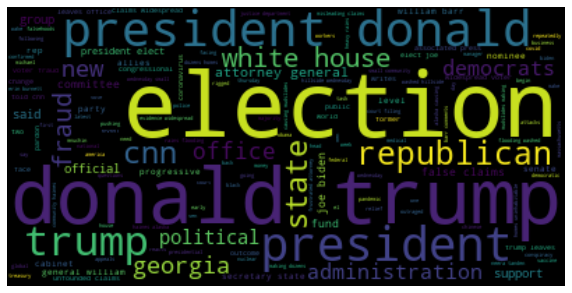

In [47]:
wordcloud_spam = WordCloud(background_color="black").generate(all_corpus_text)

# plot the word cloud
plt.figure(figsize = (10,10))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

In [52]:
import sklearn.feature_extraction.text as text
# get ngrams
def get_ngrams(data,ngrams,max_feature):
  tfidf = text.CountVectorizer(data,ngram_range=(ngrams,ngrams),max_features=max_feature,stop_words='english')
  grams = tfidf.fit_transform(data)
  return pd.Series(np.array(grams.sum(axis=0))[0],index = tfidf.get_feature_names()).sort_values(ascending=False).head(100)
  

In [55]:
data_unigram = get_ngrams(corpus_data,ngrams=1,max_feature=5000)
data_bigram = get_ngrams(corpus_data, ngrams= 2, max_feature=5000)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

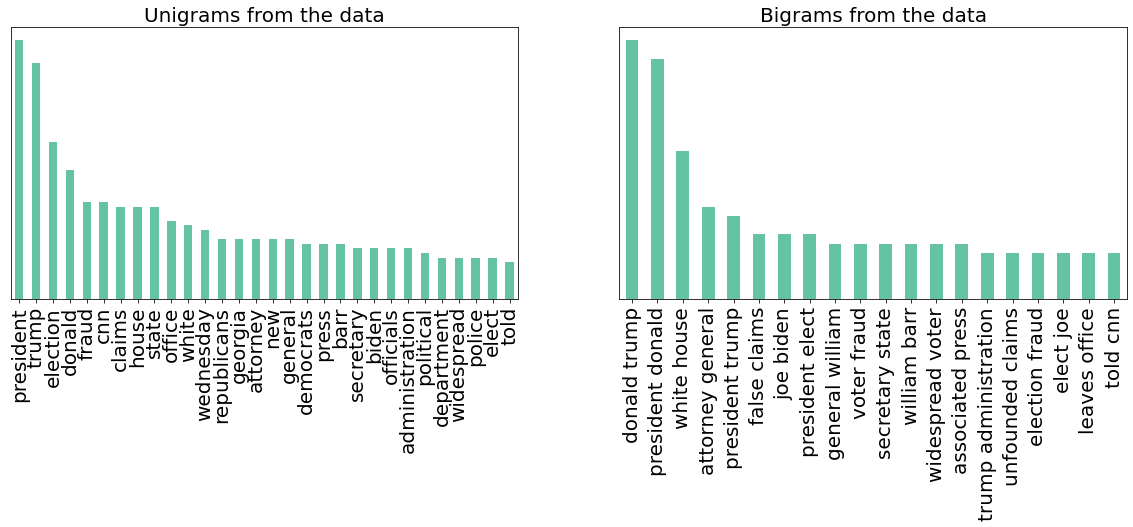

In [59]:
plt.subplot(1,2,1)
data_unigram.head(30).plot(kind="bar",figsize=(20,5),colormap='Set2')
plt.title("Unigrams from the data",fontsize=20)
plt.yticks([])
plt.xticks(size=20)

plt.subplot(1,2,2)
data_bigram.head(20).plot(kind="bar",figsize=(20,5),colormap='Set2')
plt.title("Bigrams from the data",fontsize=20)
plt.yticks([])
plt.xticks(size=20)

Here we can see that the unigram used often is 'predident' and the bigram is 'donald trump' and 'president donalt' 
Try to extract the data which containe  these words and predict the sentiment of the people about this bigram and unigram words.

In [90]:
## The data which containing this token 'donalt trump'
d = pd.Series(data['description'])
index=d.str.match(r'(?=.*\bDonald Trump\b)|(?=.*\bPresident Donald\b).*$',case=False)
donalt_trump_data=d.loc[index].tolist()


# Sentiment Analysis 
VADER (Valence Aware Dictionary and sEntiment Reasoner)

In [92]:
! pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 


     |████████████████████████████████| 133kB 5.8MB/s 


In [110]:
#creating the object
sa = SentimentIntensityAnalyzer()

#iterate through the discribtion and find the polarity score
data_scored = data['description'].apply(sa.polarity_scores).to_list()

data_scored_df = pd.DataFrame(data_scored)

#join the scores to the exsisting data
data_scored_full = data.join(data_scored_df)
data_scored_full[:8]

,description,neg,neu,pos,compound
0,"Gabriel Sterling, the voting systems implement...",0.139,0.773,0.088,-0.4404
1,President Trump and his allies are repeatedly ...,0.195,0.664,0.141,-0.3818
2,Heavy rains and flooding washed out a hillside...,0.000,1.000,0.000,0.0000
3,"Gabriel Sterling, the voting systems implement...",0.139,0.773,0.088,-0.4404
4,President Donald Trump is frustrated with Atto...,0.194,0.806,0.000,-0.8020
5,Heavy rains and flooding washed out a hillside...,0.000,1.000,0.000,0.0000
6,There are not Republicans and Democrats this m...,0.093,0.907,0.000,-0.5267
7,President Donald Trump is frustrated with Atto...,0.194,0.806,0.000,-0.8020


In [111]:
#creating the new column using the compount value in the data
conditions = [
              (data_scored_full['compound'] >= 0.5),
              (data_scored_full['compound'] > -0.5) & (data_scored_full['compound'] <= 0.5),
              (data_scored_full['compound'] <= -0.5)
]
values = ['Positive','Nutral','Negative']

data_scored_full['status'] = np.select(conditions,values)
data_scored_full[:10]

,description,neg,neu,pos,compound,status
0,"Gabriel Sterling, the voting systems implement...",0.139,0.773,0.088,-0.4404,Nutral
1,President Trump and his allies are repeatedly ...,0.195,0.664,0.141,-0.3818,Nutral
2,Heavy rains and flooding washed out a hillside...,0.000,1.000,0.000,0.0000,Nutral
3,"Gabriel Sterling, the voting systems implement...",0.139,0.773,0.088,-0.4404,Nutral
4,President Donald Trump is frustrated with Atto...,0.194,0.806,0.000,-0.8020,Negative
5,Heavy rains and flooding washed out a hillside...,0.000,1.000,0.000,0.0000,Nutral
6,There are not Republicans and Democrats this m...,0.093,0.907,0.000,-0.5267,Negative
7,President Donald Trump is frustrated with Atto...,0.194,0.806,0.000,-0.8020,Negative
8,CNN's Chris Cuomo slams Republicans who contin...,0.124,0.876,0.000,-0.4019,Nutral
9,"Amid false claims of fraud by President Trump,...",0.344,0.656,0.000,-0.8885,Negative


([], <a list of 0 Text major ticklabel objects>)

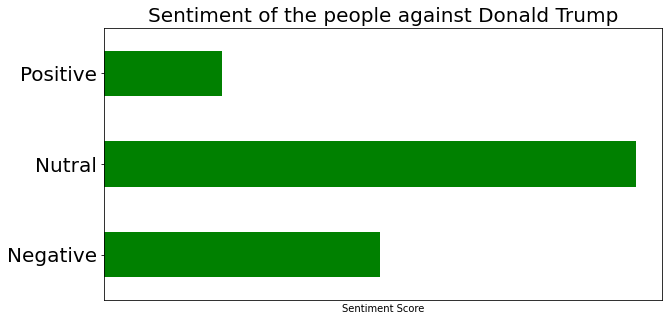

In [133]:
# plot the bar chart
sum_score = data_scored_full.groupby('status').count() 

sum_score['compound'].plot(kind='barh',figsize=(10,5),color='green', )
plt.title("Sentiment of the people against Donald Trump",fontsize=20)
plt.xlabel("Sentiment Score")
plt.ylabel("")
plt.yticks(size=20)
plt.xticks([])

